In [9]:
# Basic library
import os
import nltk
import logging
import strsimpy

import pandas as pd
import matplotlib.pyplot as plt

#from nltk.tokenize.treebank import TreebankWordDetokenizer
#from nltk.tokenize.util import align_tokens
#from nltk.tokenize.api import TokenizerI
#from nltk.tokenize.treebank import TreebankWordTokenizer
#from nltk.tokenize import word_tokenize
from recordlinkage.index import Block
import recordlinkage as rl
import recordlinkage
import jellyfish
import warnings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#pd.set_option('max_columns', 15)
pd.set_option('chained_assignment', None)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 2000)

# Record Linkage
compare = rl.Compare()

# Text
from nltk.tokenize.destructive import MacIntyreContractions
from nltk.tokenize import NLTKWordTokenizer
nltk.download('punkt')

logging.disable(level=logging.INFO)
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pierredelice/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Estandarización

In [5]:
from Modules.params import get_params
from Modules.dataset import Dataset 
params = get_params()
dataset = Dataset(params)
# Next refractor
df = dataset.get_data()

In [6]:
#Generate a copy of the data
df.columns = df.columns.str.lower()
df['name'] = df[['nombre', 'apepater', 'apemater']].astype(str).agg(' '.join, axis=1)
df['direccion'] = df[['calle', 'num', 'colonia', 'cp']].astype(str).agg(' '.join, axis=1)
df['covid'] = df['clascovid19'].map({
    'NEGATIVO ANT': 'negativo',
    'NEGATIVO': 'negativo',
    'CONF ANT': 'positivo',
    'CONF LAB': 'positivo',
    'CONF ASO': 'positivo',
    'CONF DIC': 'positivo',
    'SOSPECHOSO': 'sospechoso',
    'INVALIDO': 'invalido'
})
df = df.drop(['clascovid19'], axis=1)
df = df[[
    'name', 'nombre', 'apepater', 'apemater', 'sexo', 'fecnaci', 'edad',
    'curp', 'direccion', 'telefono', 'entnaci', 'entresi', 'mpioresi',
    'esindige', 'hableind', 'ocupacio', 'fecdef', 'covid','fechreg', 'fecinisi'
]]
df['name_len'] = (df.name
                  .apply(lambda x: len(x) if pd.notnull(x) else 0)
                  )
#df.to_csv('covidgro.csv', index=False)

NameError: name 'pd' is not defined

# **Indexation using Blocking**

## Indexing and comparation

Se aplicarán diferentes combinaciones de indexacion considerando los de datos de identidad de la persona (nombre completo, sexo, fecha de nacimiento y lugar de residencia 

In [43]:
from recordlinkage.standardise import phonetic
class soundex():
    def soundex_met(df):
        return df.assign(nombre_soundex=phonetic(df['nombre'],
                                                 method='soundex'),
                         pater_soundex=phonetic(df['apepater'],
                                                method='soundex'),
                         mater_soundex=phonetic(df['apemater'],
                                                method='soundex'))

    def result(df):
        return df.assign(
            id_soundex=df[['nombre_soundex', 'pater_soundex', 'mater_soundex'
                           ]].astype(str).agg(''.join, axis=1))
        return nombre_soundex, pater_soundex, mater_soundex, id_soundex

df = soundex.soundex_met(df)
df = soundex.result(df)

In [44]:
block_id_soundex = Block(on=['id_soundex'])
block_id_s = block_id_soundex.index(df)
#print(f"No of pairs: {len(block_id_s)}")

In [45]:
from recordlinkage.standardise import phonetic

df['nysiis'] = phonetic(df['name'], method="nysiis")
df['soundex'] = phonetic(df['name'], method="soundex")
df['metaphone'] = phonetic(df['name'], method="metaphone")
df['match_rating'] = phonetic(df['name'], method="match_rating")
#df[['name', 'nysiis', 'soundex', 'metaphone', 'match_rating']].describe()

In [46]:
import time
start_time = time.time()

#Blocking for CANDIDATE PAIRS
Block_id_soundex = Block(on=['id_soundex']) # nombtre completo transformado en soundex
Block_name = Block(on=['name', 'fecnaci']) #nombre completo con fecha de nacimiento
Block_fullid = Block(on=['name', 'fecnaci', 'sexo']) #nombre completo + fecha nacimiento+sexo
Block_pub = Block(
    on=["fecnaci", "mpioresi", "esindige", "ocupacio", "hableind"]) #con datos publicos

Block_name_pairs = Block_name.index(df)
Block_id_soundex= Block_id_soundex.index(df)
Block_fullid_pairs = Block_fullid.index(df)
Block_pub_pairs = Block_pub.index(df)

pairs = Block_name_pairs.union(Block_id_soundex)
pairs = pairs.union(Block_fullid_pairs)
pairs = pairs.union(Block_pub_pairs)

print(f"Total Records: {len(df)} records")
print(f"No of Pairs from name+fecnaci: {len(Block_name_pairs)} pairs")
print(f"No of pairs from id soundex: {len(Block_id_soundex)} pairs")
print(f"No of pairs from fullid name+fecnaci+sexo: {len(Block_fullid_pairs)} pairs")
print(f"No of pairs from public info: {len(Block_pub_pairs)} pairs")
print(f"Union pairs: {len(pairs)} pairs")
print("--- %s seconds ---" % (time.time() - start_time))
#df = df.drop(columns=[ 'telefono', 'entnaci', 'entresi',
#    'esindige', 'hableind', 'ocupacio', 'fecdef', 'covid'])

Total Records: 175834 records
No of Pairs from name+fecnaci: 18200 pairs
No of pairs from id soundex: 23826 pairs
No of pairs from fullid name+fecnaci+sexo: 18133 pairs
No of pairs from public info: 46841 pairs
Union pairs: 54776 pairs
--- 1.240947961807251 seconds ---


In [47]:
var = df[[
    'nombre', 'apepater', 'apemater', 'curp','direccion', 'fecnaci','name_len'
]]

### Levenshtein

In [48]:
# Comparison using Levenshtein method
from recordlinkage.compare import String

start_time = time.time()

algo = 'levenshtein'
var = df[[
    'nombre', 'apepater', 'apemater', 'curp',
    'direccion', 'fecnaci','name_len'
]]
compare = recordlinkage.Compare([
    String(var.columns[0], var.columns[0], method=algo, label=var.columns[0]),
    String(var.columns[1], var.columns[1], method=algo, label=var.columns[1]),
    String(var.columns[2], var.columns[2], method=algo, label=var.columns[2]),
    String(var.columns[3], var.columns[3], method=algo, label=var.columns[3]),
    String(var.columns[4], var.columns[4], method=algo, label=var.columns[4]),
    String(var.columns[5], var.columns[5], method=algo, label=var.columns[5])
])
lsim = compare.compute(pairs, df)
# lsim.sum(axis=1).value_counts().sort_index(ascending=False)
lsim_dup = lsim[lsim.sum(axis=1) >= 0]
lsim_dup['lsim'] = lsim_dup.loc[:, 'nombre':'fecnaci'].sum(axis=1)
#print(lsim.corr('kendall'))

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.037245750427246 seconds ---


### Damerau-Levenshtein

In [49]:
# Comparison using damerau_levenshtein methd
compare = recordlinkage.Compare()
algo = 'damerau_levenshtein'
compare = recordlinkage.Compare([
    String(var.columns[0], var.columns[0], method=algo, label=var.columns[0]),
    String(var.columns[1], var.columns[1], method=algo, label=var.columns[1]),
    String(var.columns[2], var.columns[2], method=algo, label=var.columns[2]),
    String(var.columns[3], var.columns[3], method=algo, label=var.columns[3]),
    String(var.columns[4], var.columns[4], method=algo, label=var.columns[4]),
    String(var.columns[5], var.columns[5], method=algo, label=var.columns[5])
])

dlsim = compare.compute(pairs, df)
# lsim.sum(axis=1).value_counts().sort_index(ascending=False)
dlsim_dup = dlsim[dlsim.sum(axis=1) >= 0]
dlsim_dup['dlsim'] = dlsim_dup.loc[:, 'nombre':'fecnaci'].sum(axis=1)
# dlsim

### Jaro Winkler

In [50]:
# Comparison using jarowinkler methd
start_time = time.time()
compare = recordlinkage.Compare()
algo = 'jarowinkler'
compare = recordlinkage.Compare([
    String(var.columns[0], var.columns[0], method=algo, label=var.columns[0]),
    String(var.columns[1], var.columns[1], method=algo, label=var.columns[1]),
    String(var.columns[2], var.columns[2], method=algo, label=var.columns[2]),
    String(var.columns[3], var.columns[3], method=algo, label=var.columns[3]),
    String(var.columns[4], var.columns[4], method=algo, label=var.columns[4]),
    String(var.columns[5], var.columns[5], method=algo, label=var.columns[5])
])

jwsim = compare.compute(pairs, df)
#lsim.sum(axis=1).value_counts().sort_index(ascending=False)
jwsim_dup = jwsim[jwsim.sum(axis=1) >= 0]
jwsim_dup['jwsim'] = jwsim_dup.loc[:, 'nombre':'fecnaci'].sum(axis=1)
#jwsim.corr()

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.5639419555664062 seconds ---


### Q-Gram

In [51]:
# Comparison using qgram method
start_time = time.time()
compare = recordlinkage.Compare()

algo = 'qgram'
compare = recordlinkage.Compare([
    String(var.columns[0], var.columns[0], method=algo, label=var.columns[0]),
    String(var.columns[1], var.columns[1], method=algo, label=var.columns[1]),
    String(var.columns[2], var.columns[2], method=algo, label=var.columns[2]),
    String(var.columns[3], var.columns[3], method=algo, label=var.columns[3]),
    String(var.columns[4], var.columns[4], method=algo, label=var.columns[4]),
    String(var.columns[5], var.columns[5], method=algo, label=var.columns[5])
])

qgsim = compare.compute(pairs, df)
#lsim.sum(axis=1).value_counts().sort_index(ascending=False)
qgsim_dup = qgsim[qgsim.sum(axis=1) >= 0]
qgsim_dup['qgsim'] = qgsim_dup.loc[:, 'nombre':'fecnaci'].sum(axis=1)
#qgsim
print("--- %s seconds ---" % (time.time() - start_time))

--- 6.020977973937988 seconds ---


### Cosine

In [52]:
# Comparison using cosine method
start_time = time.time()
compare = recordlinkage.Compare()
algo = 'cosine'
compare = recordlinkage.Compare([
    String(var.columns[0], var.columns[0], method=algo, label=var.columns[0]),
    String(var.columns[1], var.columns[1], method=algo, label=var.columns[1]),
    String(var.columns[2], var.columns[2], method=algo, label=var.columns[2]),
    String(var.columns[3], var.columns[3], method=algo, label=var.columns[3]),
    String(var.columns[4], var.columns[4], method=algo, label=var.columns[4]),
    String(var.columns[5], var.columns[5], method=algo, label=var.columns[5])
])

csim = compare.compute(pairs, df)
#lsim.sum(axis=1).value_counts().sort_index(ascending=False)
csim_dup = csim[csim.sum(axis=1) >= 0]
csim_dup['csim'] = csim_dup.loc[:, 'nombre':'fecnaci'].sum(axis=1)
#csim
print("--- %s seconds ---" % (time.time() - start_time))

--- 6.0811567306518555 seconds ---


### Jaccard

In [53]:
#Selecionar las variables de identificacion
selec = [
    'nombre', 'apepater', 'apemater', 'curp','direccion', 'fecnaci','name_len'
]

#seleccionar las variables de identificacion de la base df
jac = df[selec].reset_index()

# concatenar las bases con las metricas de distancia
#dup = [lsim_dup, dlsim_dup, jwsim_dup, qgsim_dup, csim_dup]
sim = pd.concat([lsim_dup, dlsim_dup, jwsim_dup, qgsim_dup, csim_dup],
                axis=1).reset_index()

#crear bases para cada indice
index0 = sim[['level_0']].reset_index()
index1 = sim[['level_1']].reset_index()
dup_level = sim[['level_0', 'level_1']]

In [61]:
jac0 = index0.merge(jac,
                    right_on='index',
                    left_on='level_0',
                    suffixes=('_left', '_right'),
                    sort=False)
#jac0 = jac0.set_index('level_0').drop(['index_right', 'index_left'],
#                                      axis=1).reset_index()
d = pd.concat([dup_level, jac0], axis=1)

#d.reset_index(inplace=True)
d.set_index('level_1', inplace=True)
d.reset_index(inplace=True)
d = d.merge(jac, left_on='level_1', right_on='index')
cols = [0, 1]
d.drop(d.columns[cols], axis=1, inplace=True)
d = d.rename(columns={'index_right': 'level_0', 'index': 'level_1'})
d = d[[
    'level_0', 'level_1','nombre_x', 'nombre_y', 
    'apepater_x', 'apepater_y', 'apemater_x',
    'apemater_y', 'curp_x', 'curp_y', 'fecnaci_x', 
    'fecnaci_y', 'direccion_x','direccion_y'
]].set_index(['level_0', 'level_1'])
d.columns = d.columns.str.replace('_x', '', regex=True)
d.columns = d.columns.str.replace('_y', '1', regex=True)

Calculo del Jaccard compuesto de todas las variables

In [55]:
from jaccard import *
# Aplicar el algoritmo de Jaccard a la base de datos
start_time = time.time()

jac_ = d.copy()
selec = [
    'nombre', 'apepater', 'apemater', 'curp', 'fecnaci',
    'direccion'
]

selec1 = [
    'nombre1', 'apepater1', 'apemater1', 'curp1',
    'fecnaci1', 'direccion1'
]

for i, var in enumerate(selec):
    jac_['jaccsim_' + var] = (jac_[[var, selec1[i]]]
                              .astype(str)
                              .apply(lambda s: jaccard_h(ngrams(s[0], 2),
                                                         ngrams(s[1], 2)), axis=1)
                              )

# Sumar los valores en un indice
jaccsim = jac_.loc[:, 'jaccsim_nombre':'jaccsim_direccion']
jaccsim_dup = jaccsim[jaccsim.sum(axis=1) >= 0]
jaccsim_dup['jaccsim'] = jac_.loc[:, 'jaccsim_nombre':'jaccsim_direccion'].sum(
    axis=1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 4.151961803436279 seconds ---


### Longest Common Substring (LCS)

In [56]:
from LCS import *
# Aplicar el algoritmo de Longest Common Substring a la base de datos
start_time = time.time()

selec = [
    'nombre', 'apepater', 'apemater', 'curp', 'fecnaci','direccion'
]

selec1 = [
    'nombre1', 'apepater1', 'apemater1', 'curp1','fecnaci1', 'direccion1'
]

for i, var in enumerate(selec):
    jac_['lcssim_' + var] = (jac_[[var, selec1[i]]]
                             #.astype(str)
                             .apply(lambda s: longest_common_substring_similarity(s[[0]], s[[1]], norm='dice', min_len=2), axis=1)
                             )

# Sumar los valores en un indice
lcssim = jac_.loc[:, 'lcssim_nombre':'lcssim_direccion']
lcssim_dup = lcssim[lcssim.sum(axis=1) >= 0]
lcssim_dup['lcssim'] = jac_.loc[:,
                                'lcssim_nombre':'lcssim_direccion'].sum(axis=1)

print("--- %s seconds ---" % (time.time() - start_time))

--- 146.12630200386047 seconds ---


### Longest Common Subsequence

In [57]:
from strsimpy.metric_lcs import MetricLCS

start_time = time.time()
#Metric_lcs calcula la distancia entre 2 cadenas,
#asignando 0 cuando se empatan por lo que se se invierte con -1
#metric_lcs - 1

metric_lcs = MetricLCS()

# Aplicar el algoritmo de Longest Common Subsequence a la base de datos
start_time = time.time()

selec = [
    'nombre', 'apepater', 'apemater', 'curp', 'fecnaci','direccion'
]

selec1 = [
    'nombre1', 'apepater1', 'apemater1', 'curp1','fecnaci1', 'direccion1'
]

for i, var in enumerate(selec):
    jac_['LCSubSecsim_' + var] = (1 - jac_[[var, selec1[i]]]
                                  .astype(str)
                                  .apply(lambda s: metric_lcs.distance(s[0], s[1]), axis=1)
                                  )

# Sumar los valores en un indice
LCSubSecsim = jac_.loc[:, 'LCSubSecsim_nombre':'LCSubSecsim_direccion']
LCSubSecsim_dup = LCSubSecsim[LCSubSecsim.sum(axis=1) >= 0]
LCSubSecsim_dup['LCSubSecsim'] = jac_.loc[:, 'LCSubSecsim_nombre':
                                          'LCSubSecsim_direccion'].sum(axis=1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 23.75437092781067 seconds ---


### Smith-Waterman

In [62]:
from SmithWaterman import *
start_time = time.time()
selec = [
    'nombre', 'apepater', 'apemater', 'curp', 'fecnaci','direccion'
]

selec1 = [
    'nombre1', 'apepater1', 'apemater1', 'curp1','fecnaci1', 'direccion1'
]

for i, var in enumerate(selec):
    jac_['SWsim_' + var] = (jac_[[var, selec1[i]]]
                            .astype(str)
                            .apply(lambda s: smith_waterman_similarity(s[[0]],
                                            s[[1]],
                                            match=5,
                                            mismatch=-5,
                                            gap_start=-5,
                                            gap_continue=-1,
                                            norm="mean"),axis=1)
                            )

# Sumar los valores en un indice
SWsim = jac_.loc[:, 'SWsim_nombre':'SWsim_direccion']
SWsim_dup = SWsim[SWsim.sum(axis=1) >= 0]
SWsim_dup['SWsim'] = jac_.loc[:, 'SWsim_nombre':'SWsim_direccion'].sum(axis=1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 151.69007110595703 seconds ---


# Sum of index

In [63]:
#rename index
idx = [lsim_dup, dlsim_dup, jwsim_dup, qgsim_dup, csim_dup]
for x in idx:
    x = x.index.set_names(['level_0', 'level_1'], inplace=True)

In [64]:
lsim_dup.columns = [
    'lsim_' + x if (x != 'lsim' and x.find('lsim')) else x
    for x in lsim_dup.columns
]

dlsim_dup.columns = [
    'dlsim_' + x if (x != 'dlsim' and x.find('dlsim')) else x
    for x in dlsim_dup.columns
]

jwsim_dup.columns = [
    'jwsim_' + x if (x != 'jwsim' and x.find('jwsim')) else x
    for x in jwsim_dup.columns
]

qgsim_dup.columns = [
    'qgsim_' + x if (x != 'qgsim' and x.find('qgsim')) else x
    for x in qgsim_dup.columns
]

csim_dup.columns = [
    'csim_' + x if (x != 'csim' and x.find('csim')) else x
    for x in csim_dup.columns
]

In [65]:
## Join all the similarity measures
dup = [
    lsim_dup, dlsim_dup, jwsim_dup, qgsim_dup, csim_dup, jaccsim_dup,
    lcssim_dup, LCSubSecsim_dup, SWsim_dup
]
sim = pd.concat(dup, axis=1)

Text(0, 0.5, 'número de registros')

Text(0.5, 1.0, 'Número de registros usando el nombre')

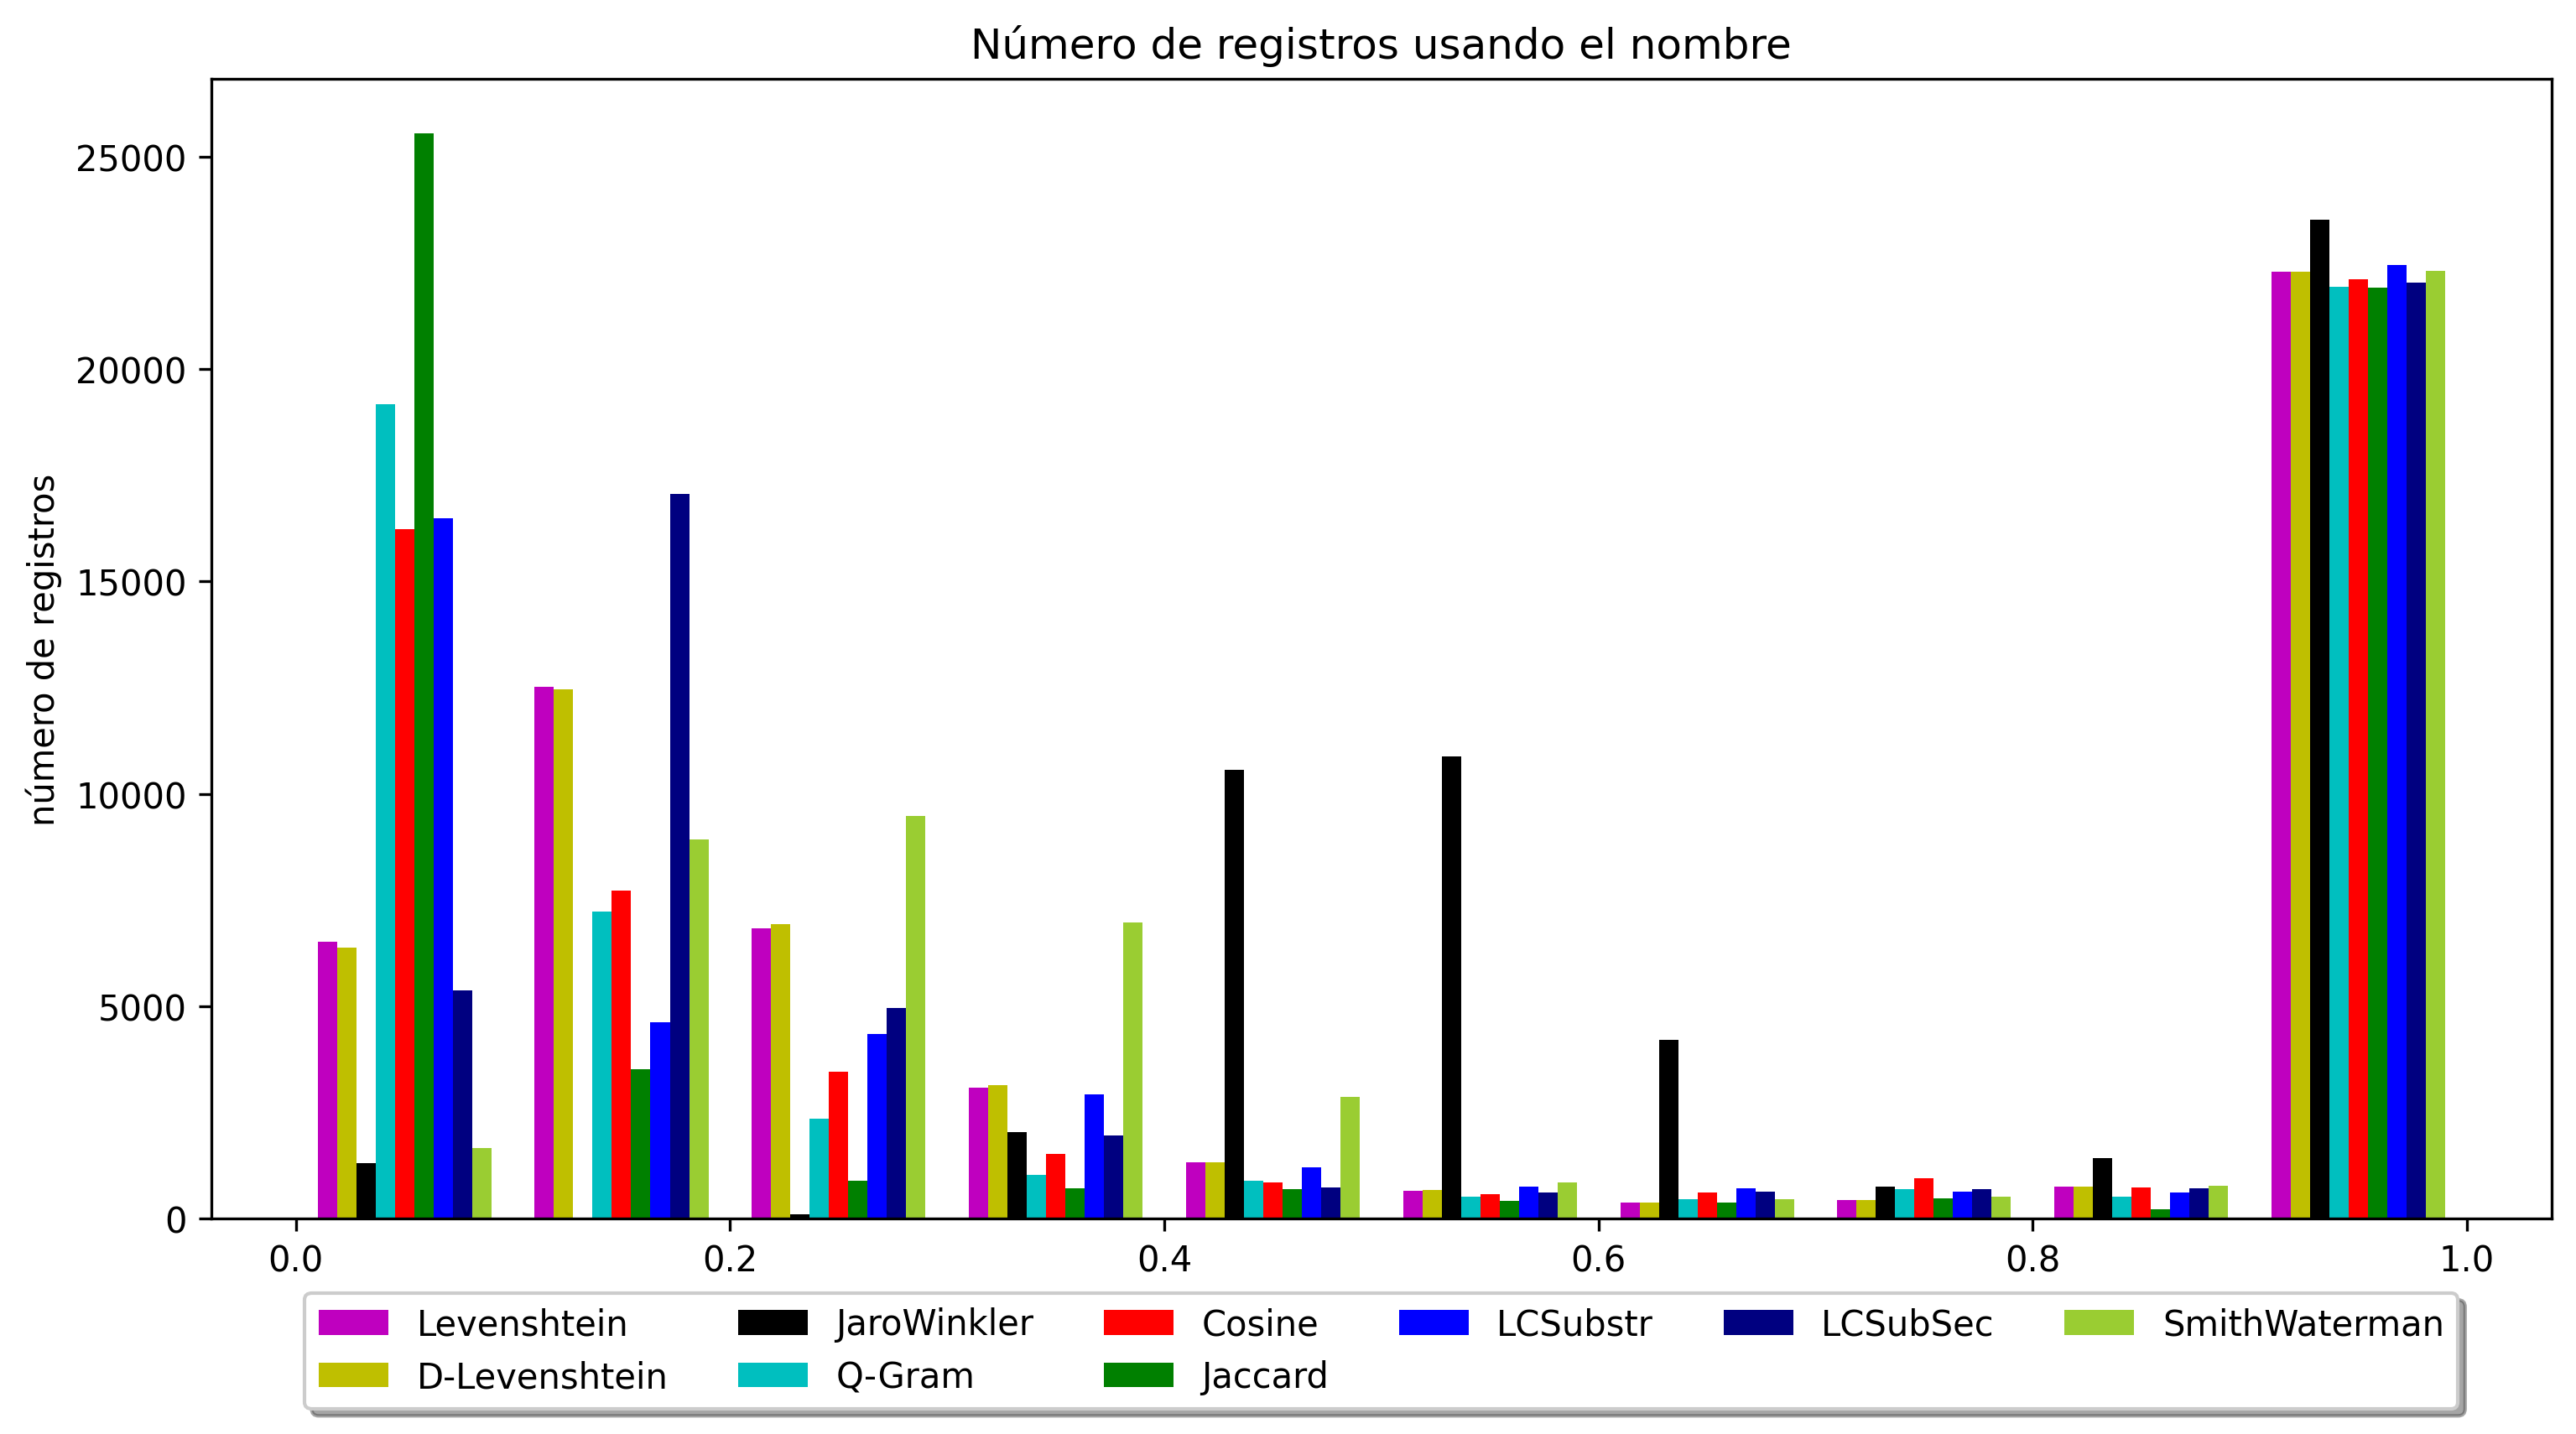

In [66]:

#Grafica
f, ax1 = plt.subplots(dpi=300,sharey=True)
f.set_size_inches(12,6)
_ = ax1.hist(sim[[
    'lsim_nombre', 'dlsim_nombre', 'jwsim_nombre', 'qgsim_nombre',
    'csim_nombre', 'jaccsim_nombre', 'lcssim_nombre', 'SWsim_nombre',
    'LCSubSecsim_nombre'
]].values,
             color=['m', 'y', 'k', 'c', 'r', 'g', 'b', 'navy', 'yellowgreen'],  # type: ignore
             label=[
                 'Levenshtein', 'D-Levenshtein', 'JaroWinkler', 'Q-Gram',
                 'Cosine', 'Jaccard', 'LCSubstr', 'LCSubSec', 'SmithWaterman'
             ],  # type: ignore
             histtype='bar')
_ = ax1.legend(loc='upper center',
               bbox_to_anchor=(0.5, -0.05),
               ncol=6,
               fancybox=True,
               shadow=True)
plt.ylabel('número de registros')
plt.title('Número de registros usando el nombre')
#f.savefig('nombre.png')
plt.show()

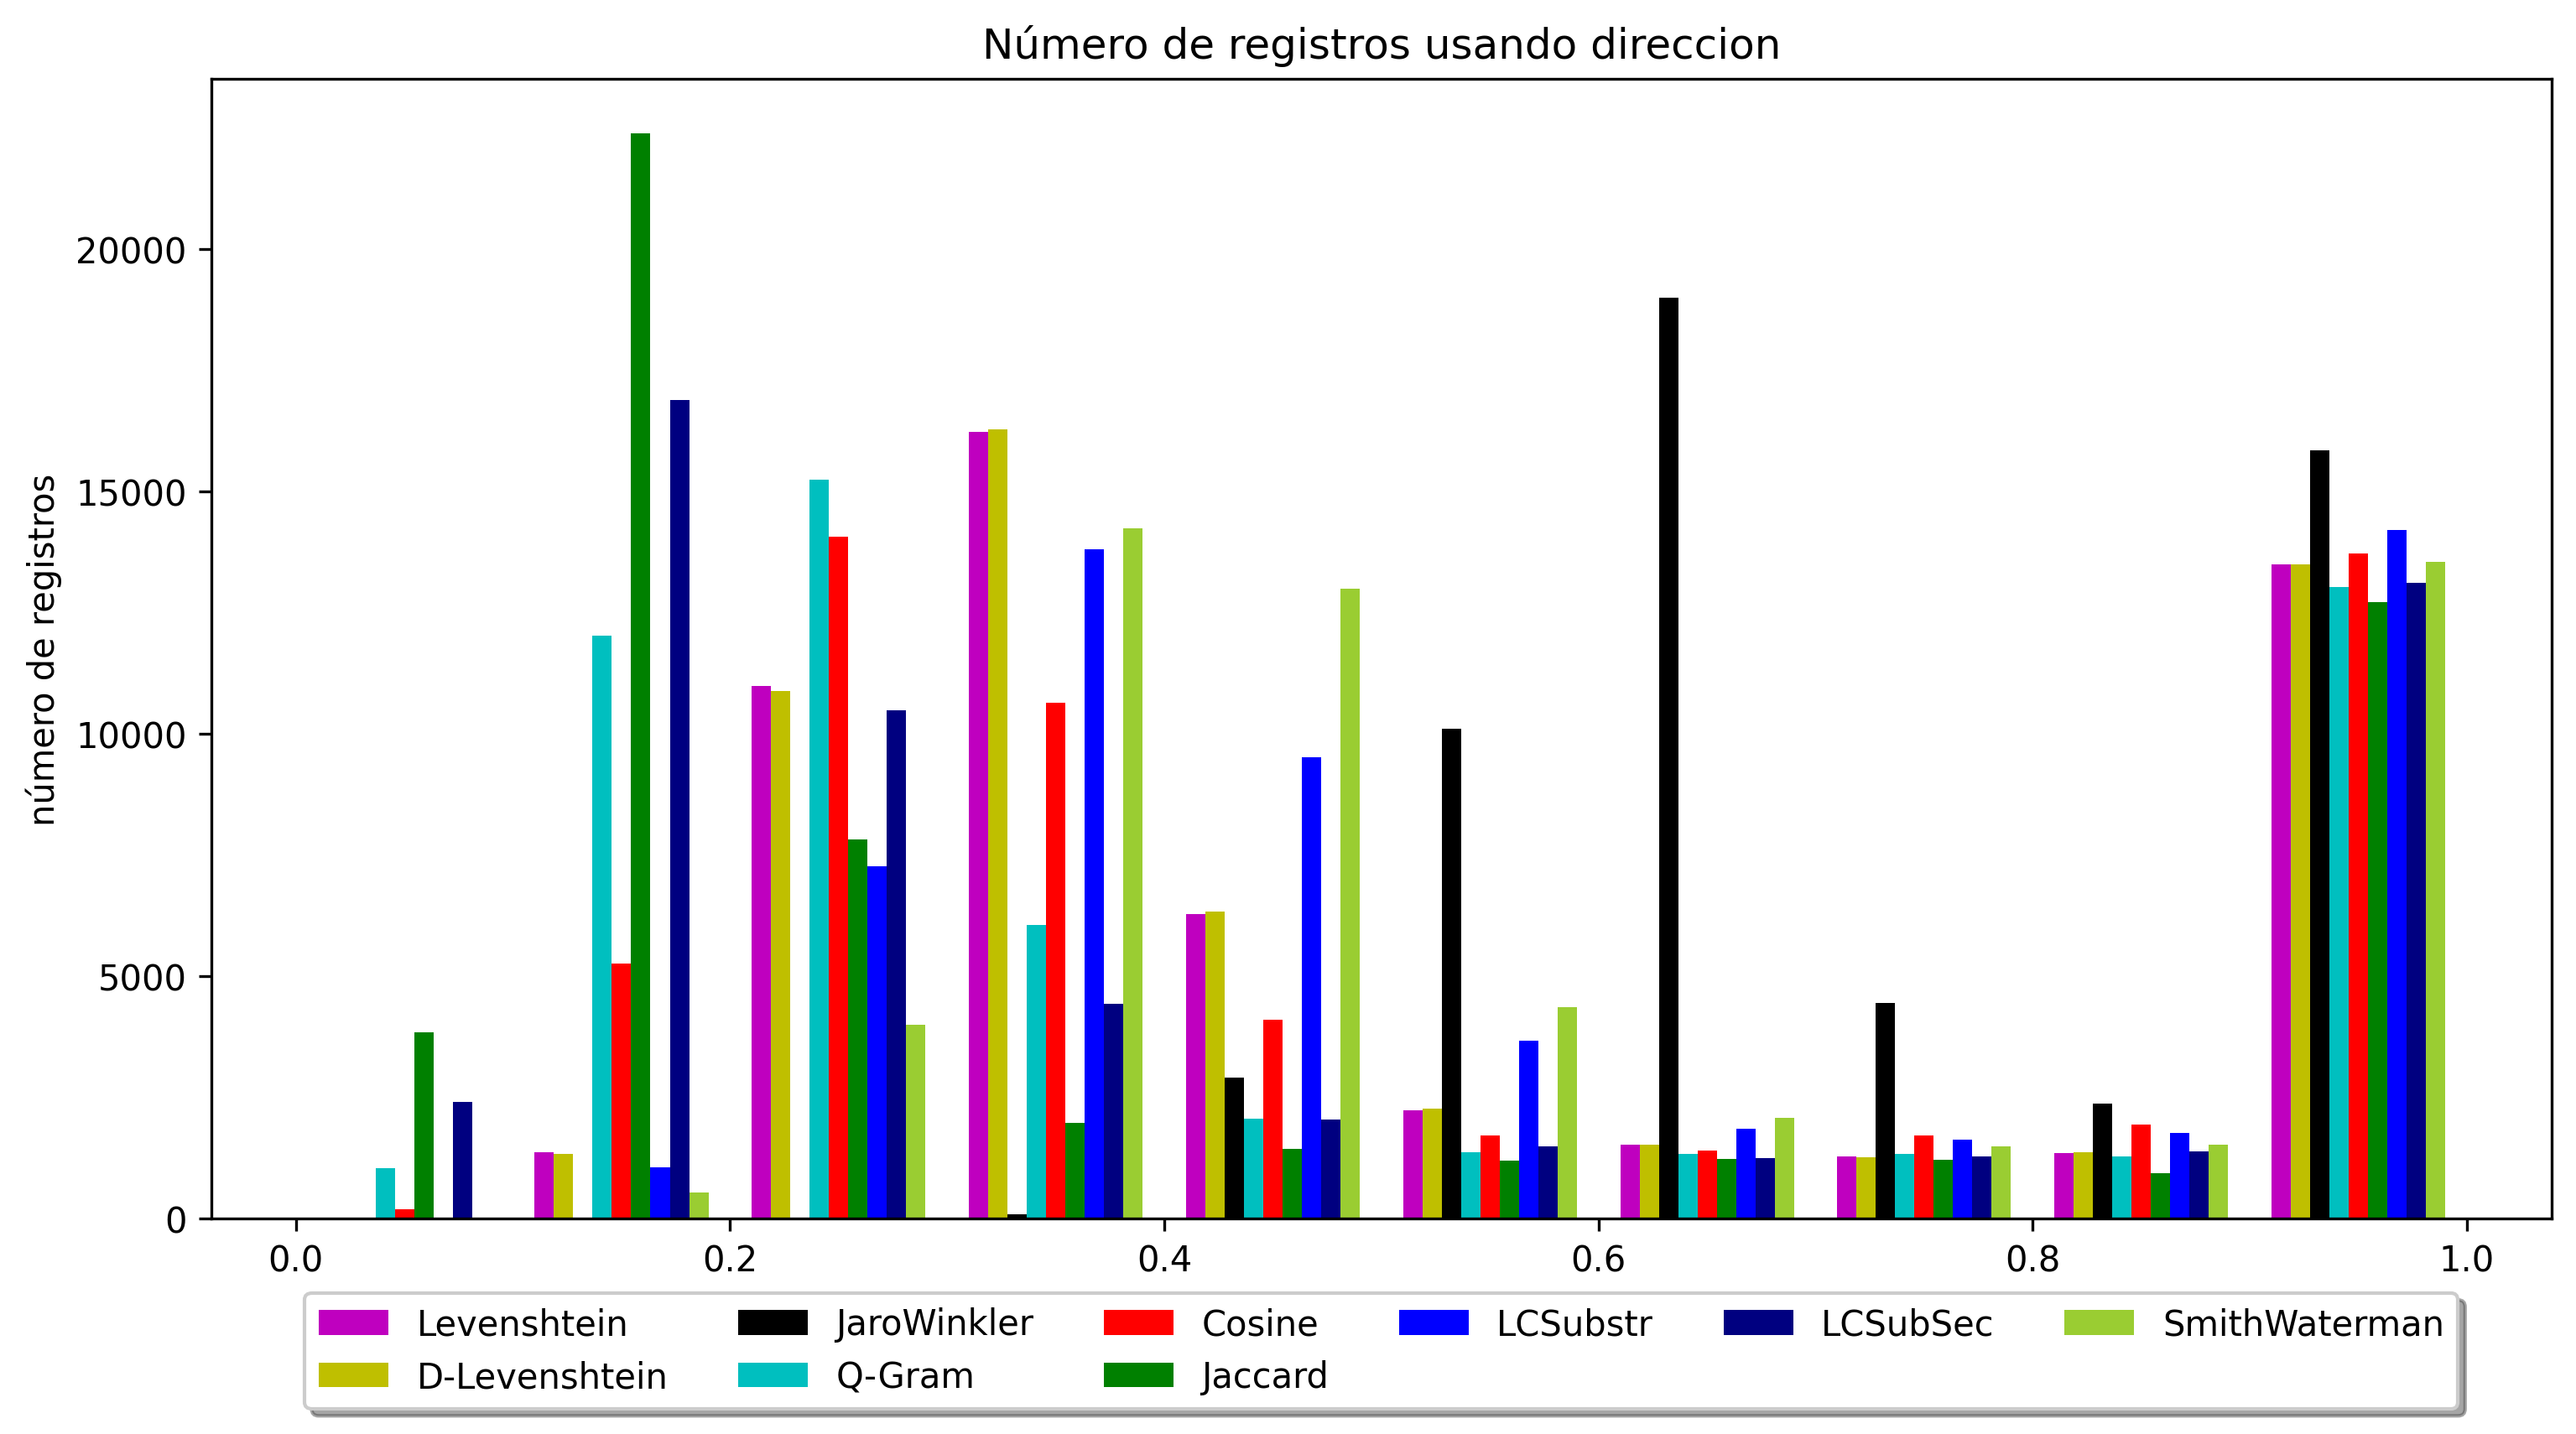

In [67]:
#Grafica
f, ax1 = plt.subplots(dpi=300,sharey=True)
f.set_size_inches(12, 6)
_ = ax1.hist(sim[[
    'lsim_direccion', 'dlsim_direccion', 'jwsim_direccion', 'qgsim_direccion',
    'csim_direccion', 'jaccsim_direccion', 'lcssim_direccion',
    'SWsim_direccion', 'LCSubSecsim_direccion'
]].values,
             color=['m', 'y', 'k', 'c', 'r', 'g', 'b', 'navy', 'yellowgreen'],  # type: ignore
             label=[
                 'Levenshtein', 'D-Levenshtein', 'JaroWinkler', 'Q-Gram',
                 'Cosine', 'Jaccard', 'LCSubstr', 'LCSubSec', 'SmithWaterman'
             ],  # type: ignore
             histtype='bar')
_ = ax1.legend(loc='upper center',
               bbox_to_anchor=(0.5, -0.05),
               ncol=6,
               fancybox=True,
               shadow=True)
plt.ylabel('número de registros')
plt.title('Número de registros usando direccion')
#f.savefig('direccion.png')
plt.show();

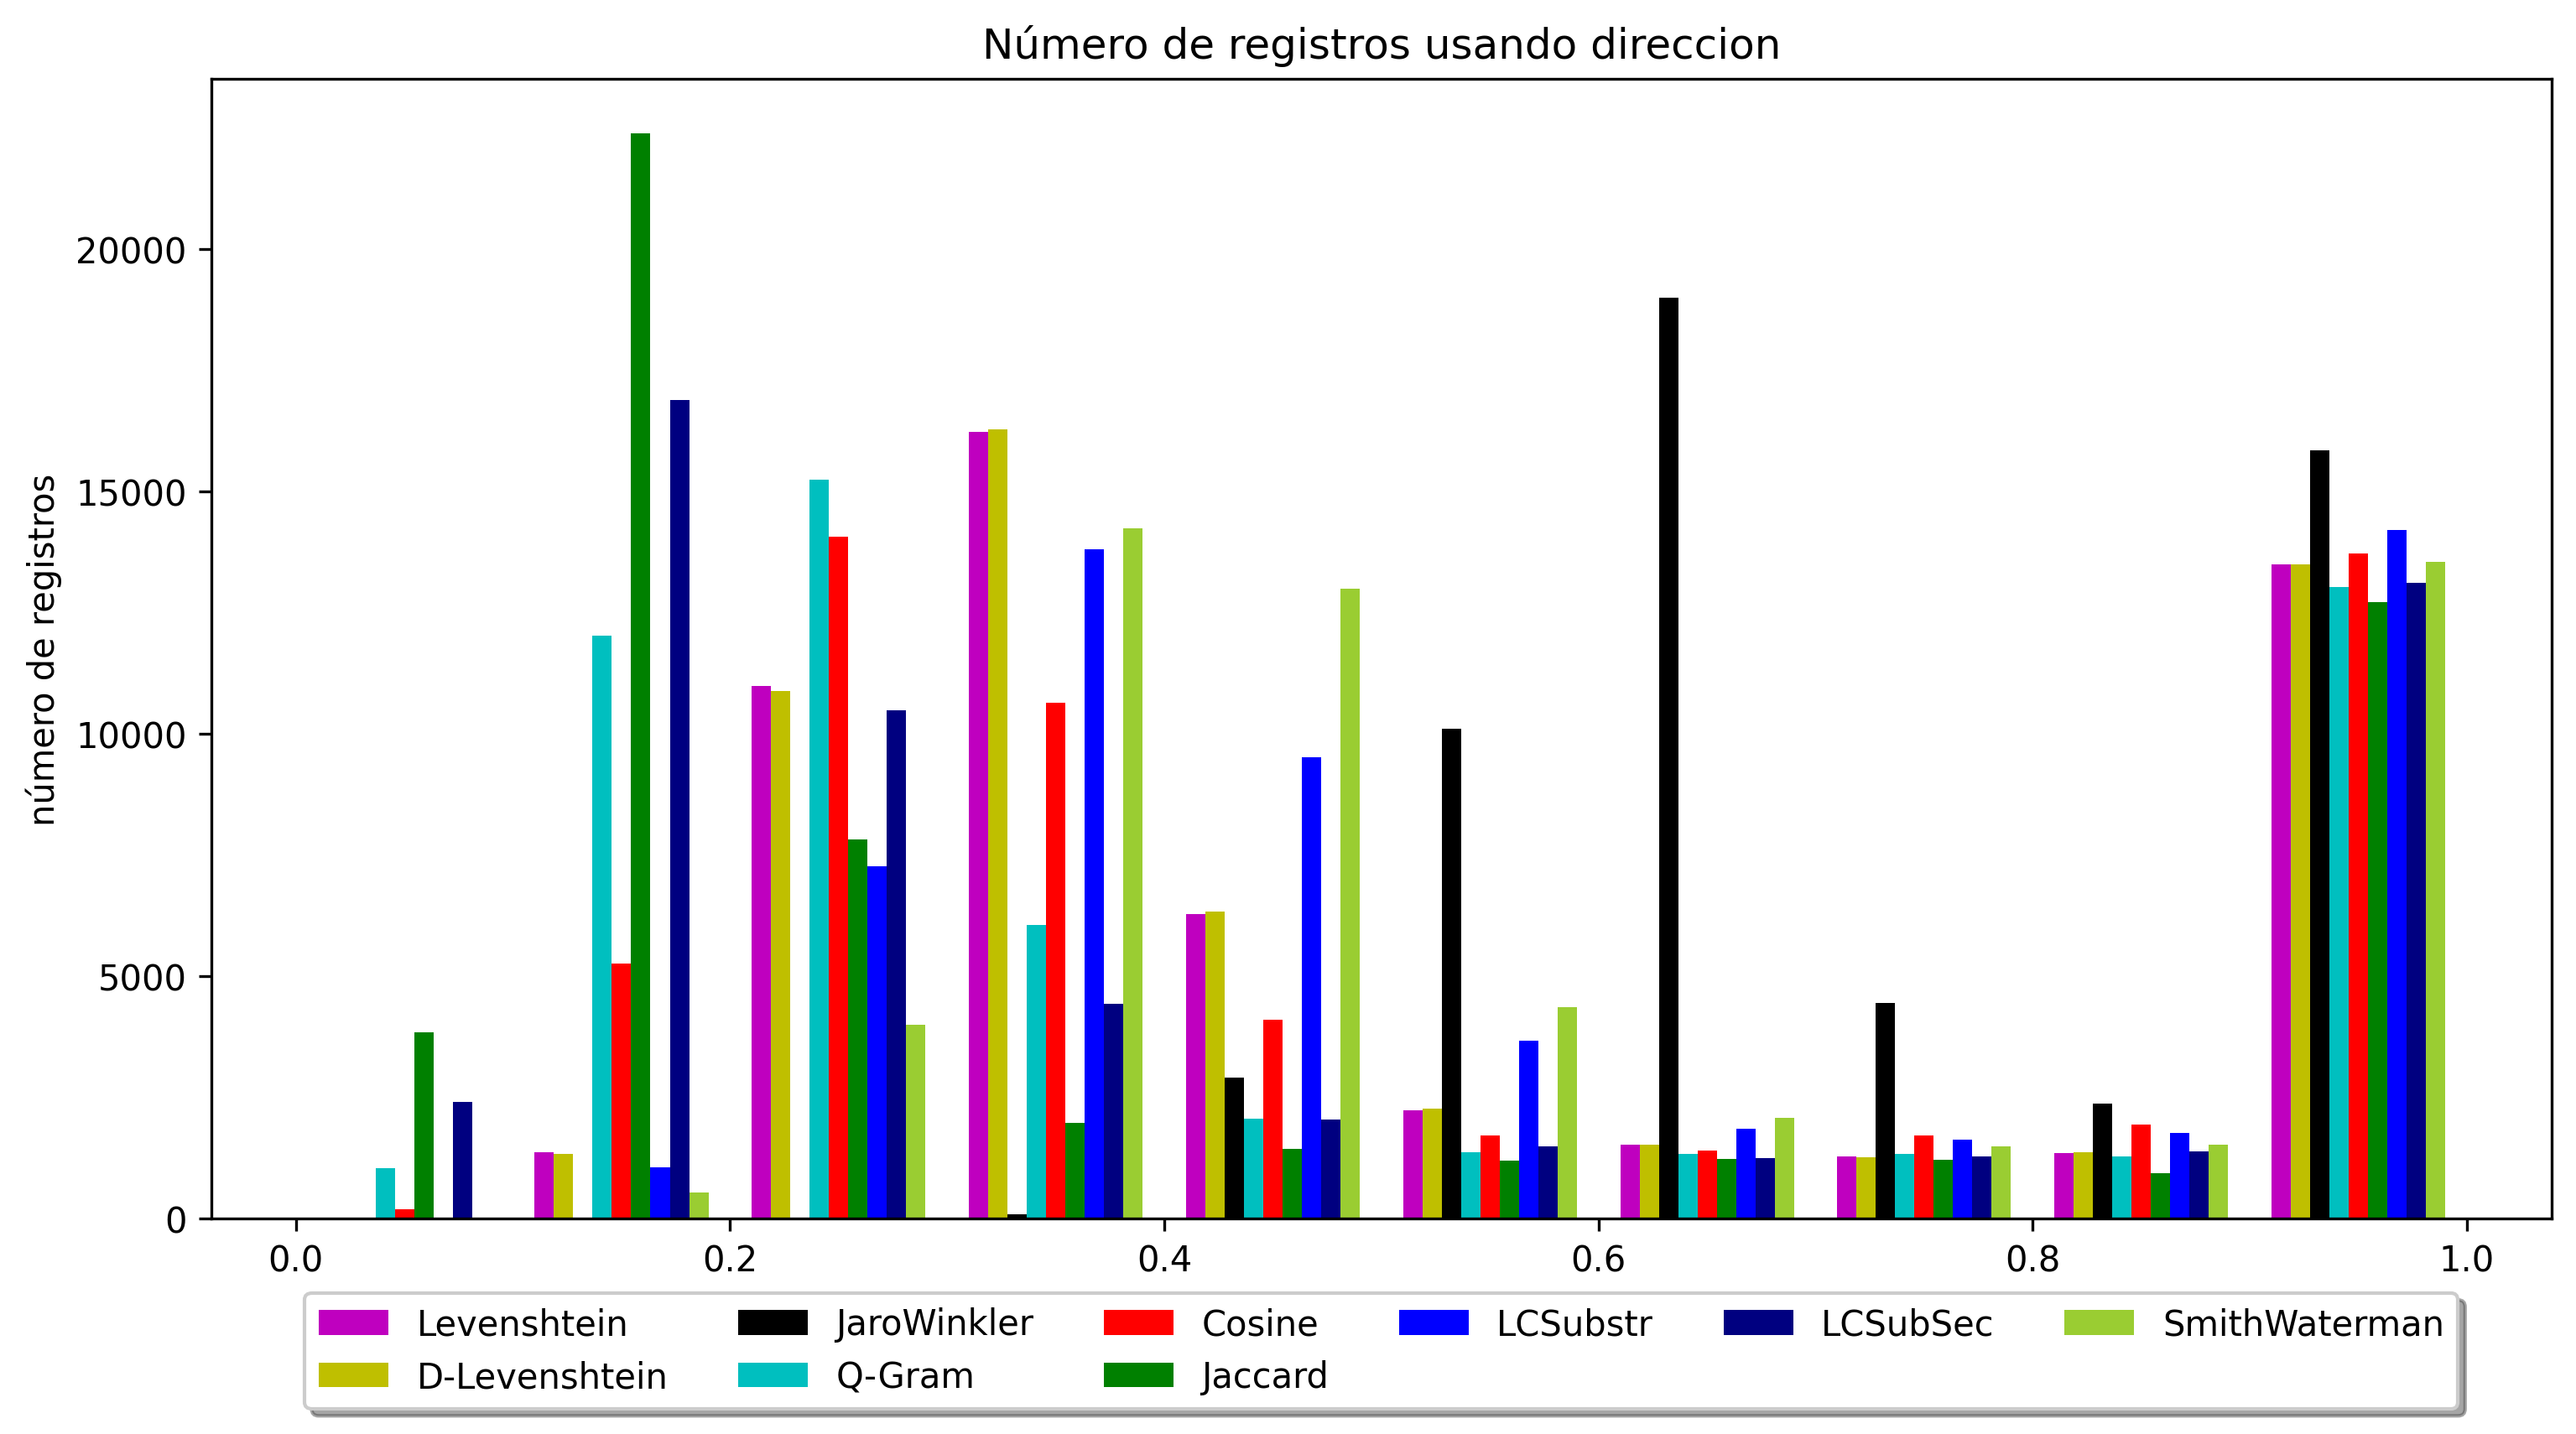

In [68]:
#Grafica
f, ax1 = plt.subplots(dpi=300,sharey=True)
f.set_size_inches(12, 6)
_ = ax1.hist(sim[[
    'lsim_direccion', 'dlsim_direccion', 'jwsim_direccion', 'qgsim_direccion',
    'csim_direccion', 'jaccsim_direccion', 'lcssim_direccion',
    'SWsim_direccion', 'LCSubSecsim_direccion'
]].values,
             color=['m', 'y', 'k', 'c', 'r', 'g', 'b', 'navy', 'yellowgreen'],  # type: ignore
             label=[
                 'Levenshtein', 'D-Levenshtein', 'JaroWinkler', 'Q-Gram',
                 'Cosine', 'Jaccard', 'LCSubstr', 'LCSubSec', 'SmithWaterman'
             ],  # type: ignore
             histtype='bar')
_ = ax1.legend(loc='upper center',
               bbox_to_anchor=(0.5, -0.05),
               ncol=6,
               fancybox=True,
               shadow=True)
plt.ylabel('número de registros')
plt.title('Número de registros usando direccion')
#f.savefig('direccion.png')
plt.show();

In [69]:
sim = sim[['lsim_nombre', 'lsim_apepater',
    'lsim_apemater', 'lsim_curp', 'lsim_direccion', 'lsim_fecnaci', 'lsim',
    'dlsim_nombre', 'dlsim_apepater',
    'dlsim_apemater', 'dlsim_curp', 'dlsim_direccion', 'dlsim_fecnaci',
    'dlsim', 'jwsim_nombre',
    'jwsim_apepater', 'jwsim_apemater', 'jwsim_curp', 'jwsim_direccion',
    'jwsim_fecnaci', 'jwsim', 'qgsim_nombre',
    'qgsim_apepater', 'qgsim_apemater', 'qgsim_curp', 'qgsim_direccion',
    'qgsim_fecnaci', 'qgsim', 'csim_nombre',
    'csim_apepater', 'csim_apemater', 'csim_curp', 'csim_direccion',
    'csim_fecnaci', 'csim', 
    'jaccsim_nombre', 'jaccsim_apepater', 'jaccsim_apemater', 'jaccsim_curp',
    'jaccsim_fecnaci', 'jaccsim_direccion', 'jaccsim', 
    'lcssim_nombre', 'lcssim_apepater', 'lcssim_apemater',
    'lcssim_curp', 'lcssim_fecnaci', 'lcssim_direccion', 'lcssim',
    'LCSubSecsim_nombre',
    'LCSubSecsim_apepater', 'LCSubSecsim_apemater', 'LCSubSecsim_curp',
    'LCSubSecsim_fecnaci', 'LCSubSecsim_direccion', 'LCSubSecsim',
    'SWsim_nombre', 'SWsim_apepater',
    'SWsim_apemater', 'SWsim_curp', 'SWsim_fecnaci', 'SWsim_direccion', 'SWsim'
]]
#sim.to_csv('simdup.csv', index=False)

Text(0.5, 0.98, 'Figure 4. Comparación de las métricas de similitud (identidad completa)')

Text(0, 0.5, 'número de registros')

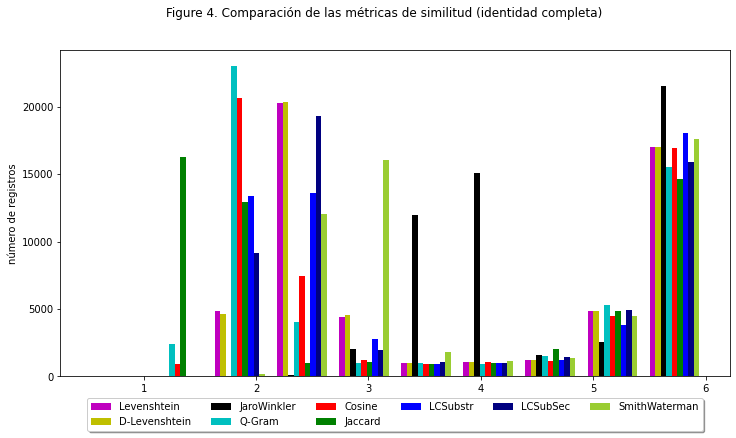

In [70]:
sim_tot = sim.loc[:, sim.columns.str.endswith('sim')]
#Grafica
f, ax1 = plt.subplots(sharey=True)
f.suptitle('Figure 4. Comparación de las métricas de similitud (identidad completa)')
f.set_size_inches(12,6)
_ = ax1.hist(sim_tot[[
    'lsim', 'dlsim', 'jwsim', 'qgsim', 'csim', 'jaccsim', 'lcssim', 'SWsim',
    'LCSubSecsim'
]].values,
             color=['m', 'y', 'k', 'c', 'r', 'g', 'b', 'navy', 'yellowgreen'],  # type: ignore
             label=[
                 'Levenshtein', 'D-Levenshtein', 'JaroWinkler', 'Q-Gram',
                 'Cosine', 'Jaccard', 'LCSubstr', 'LCSubSec', 'SmithWaterman'
             ],  # type: ignore
             histtype='bar')
_ = ax1.legend(loc='upper center',
               bbox_to_anchor=(0.5, -0.05),
               ncol=6,
               fancybox=True,
               shadow=True)
plt.ylabel('número de registros')
#plt.title('Número de registros usando el nombre completo')
#f.savefig('identidad.png',dpi=300)
plt.show();

bin_labels = ['No_Empate', 'Posible_Empate', 'Empate']
col = [
    'lsim', 'dlsim', 'jwsim', 'qgsim', 'csim', 'jaccsim', 'lcssim',
    'LCSubSecsim', 'SWsim'
]

for cols in col:
    sim[cols + 'Class'] = pd.cut(sim_tot[cols],
                                 bins=[0, 4, 5, 6],
                                 labels=bin_labels)
#col = np.sort(sim.columns)
#sim = sim.loc[:,~sim.columns.str.endswith(('name','id_soundex'))]
sim = sim[np.sort(sim.columns)]

In [71]:
#import os
#path = '/Users/pierredelice/Library/CloudStorage/Dropbox/Mac/Downloads/Bibliography_tesis_buap/ICOKG 2022/nestor_tesis/base_datos_covid/'
#output_file = os.path.join(path,'simdup.csv')
#sim.to_csv(path+'simdup.csv', index=True)

In [72]:
output = sim[sim.columns[sim.columns.str.endswith('Class')]].apply(pd.Series.value_counts).T
output['empate_%'] = round(output['Empate'] *100 / len(df),2)
output.sort_values(by='Empate')

,No_Empate,Posible_Empate,Empate,empate_%
jaccsimClass,32528,3315,18933,10.77
qgsimClass,31835,2760,20181,11.48
SWsimClass,31934,2539,20303,11.55
csimClass,31579,2235,20848,11.86
lsimClass,31018,2353,21405,12.17
dlsimClass,30985,2370,21421,12.18
lcssimClass,31089,2155,21532,12.25
LCSubSecsimClass,30555,2470,21751,12.37
jwsimClass,23216,7897,23663,13.46


LR: 0.995454 (0.001268)
LDA: 0.970151 (0.002736)
KNN: 0.995527 (0.001107)
CART: 0.994195 (0.001570)
NB: 0.960038 (0.003229)
SVM: 0.997335 (0.001078)
RFC: 0.996038 (0.000961)


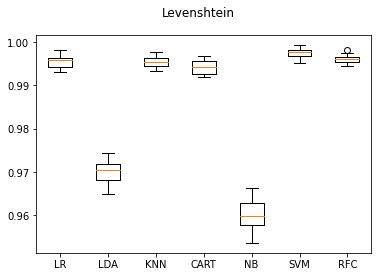

In [73]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,roc_auc_score,classification_report,roc_curve,auc, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
#import lightgbm as lgb


# load the dataset
# split into input (X) and output (y) variables
lsim = sim.loc[:,sim.columns.str.startswith('lsim')]
X = lsim.iloc[:, 2:]
y = lsim.iloc[:, 1].replace(["Empate","Posible_Empate","No_Empate"],[0,1,2])

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RFC', RandomForestClassifier()))
#models.append(('XGB', XGBClassifier()))
#models.append(('GBC', GradientBoostingClassifier()))


# evaluate each model in turn
results = []
names = []
cols=None
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=20, random_state=None, shuffle= True)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Levenshtein')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()
plt.show();

In [74]:
#Importing sklearn modules
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Application of all Machine Learning methods
MLA = [
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),

    #Ensemble Methods
    #ensemble.AdaBoostClassifier(),
    #ensemble.BaggingClassifier(),
    #ensemble.ExtraTreesClassifier(),
    #ensemble.GradientBoostingClassifier(),
    #ensemble.RandomForestClassifier(),

    #Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(),

    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),

    #Trees    
    tree.DecisionTreeClassifier(),

    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),

    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
]

MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

In [75]:
bin_labels = ['No_Empate',  'Empate']
col = [
    'lsim', 'dlsim', 'jwsim', 'qgsim', 'csim', 'jaccsim', 'lcssim',
    'LCSubSecsim', 'SWsim'
]

for cols in col:
    sim[cols + 'Class'] = pd.cut(sim_tot[cols],
                                 bins=[0, 5, 6],
                                 labels=bin_labels)
                                 

lsim = sim.loc[:,sim.columns.str.startswith('lsim')]
x = lsim.iloc[:, 2:]
y = lsim.iloc[:, 1].replace(["Empate","No_Empate"],[0,1])
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.2, random_state=0)

row_index = 0
for alg in MLA:  
    
    predicted = alg.fit(x_train, y_train).predict(x_test)
    fp, tp, th = roc_curve(y_test, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA used'] = MLA_name
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(x_train, y_train), 4)
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(x_test, y_test), 4)
    MLA_compare.loc[row_index, 'Precision'] = precision_score(y_test, predicted)  # type: ignore
    MLA_compare.loc[row_index, 'Recall'] = recall_score(y_test, predicted)  # type: ignore
    MLA_compare.loc[row_index, 'AUC'] = auc(fp, tp)

    row_index+=1
    
MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

,MLA used,Train Accuracy,Test Accuracy,Precision,Recall,AUC
0,LogisticRegressionCV,1.0000,1.0000,1.000000,1.000000,1.000000
5,SVC,0.9979,0.9986,0.999407,0.998371,0.998710
3,SGDClassifier,0.9978,0.9984,0.999111,0.998223,0.998398
11,KNeighborsClassifier,0.9980,0.9976,0.999258,0.996891,0.997850
7,LinearSVC,0.9971,0.9974,1.000000,0.995854,0.997927
8,DecisionTreeClassifier,1.0000,0.9970,0.997189,0.997927,0.996703
1,PassiveAggressiveClassifier,0.9931,0.9943,1.000000,0.990820,0.995410
4,Perceptron,0.9885,0.9910,1.000000,0.985342,0.992671
10,GaussianNB,0.9865,0.9892,0.991264,0.991264,0.988612
2,RidgeClassifierCV,0.9819,0.9842,0.998636,0.975718,0.986788


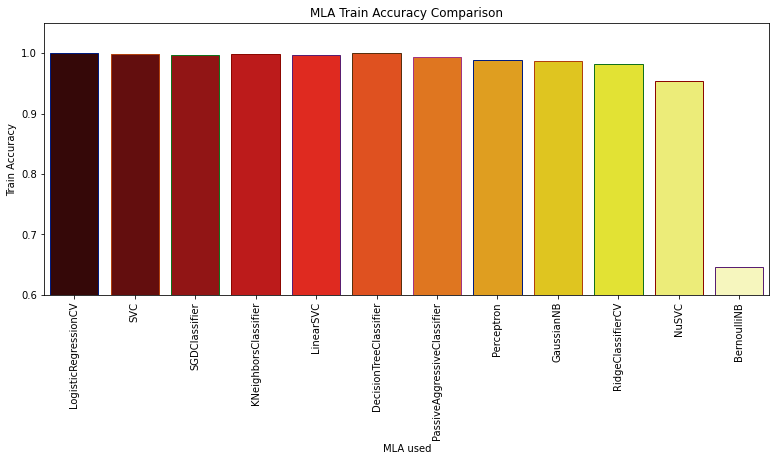

In [76]:
import seaborn as sns 
# Creating plot to show the train accuracy
plt.subplots(figsize=(13,5))
sns.barplot(x="MLA used", y="Train Accuracy",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MLA Train Accuracy Comparison')
plt.ylim(bottom=0.6)
plt.show();

LR: 0.994997 (0.002175)
LDA: 0.983638 (0.005773)
KNN: 0.996434 (0.002125)
CART: 0.994651 (0.002788)
NB: 0.987865 (0.004829)
SVM: 0.997728 (0.001143)


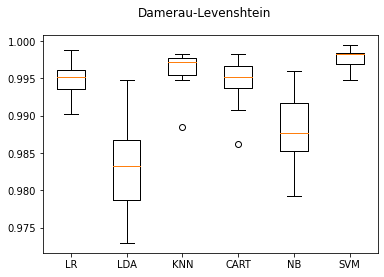

In [77]:
import matplotlib.pyplot as pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# load the dataset
# split into input (X) and output (y) variables
#X = sim.iloc[:, 0:9]
#y = sim.iloc[:, 91]

dlsim = sim.loc[:,sim.columns.str.startswith('dlsim')]
X = dlsim.iloc[20000:, 2:]
y = dlsim.iloc[20000:, 1]

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=20, random_state=None)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Damerau-Levenshtein')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show();

LR: 0.996751 (0.002288)
LDA: 0.990194 (0.004584)
KNN: 0.997556 (0.001089)
CART: 0.994623 (0.002548)
NB: 0.986657 (0.005596)
SVM: 0.998706 (0.000851)


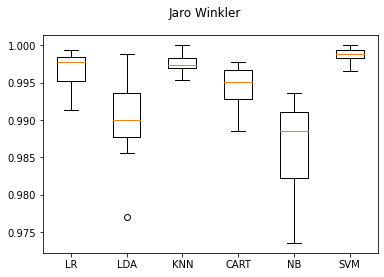

In [78]:
import matplotlib.pyplot as pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# load the dataset
jwsim = sim.loc[:,sim.columns.str.startswith('jwsim')]
X = jwsim.iloc[20000:, 2:]
y = jwsim.iloc[20000:, 1]

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=20, random_state=None)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Jaro Winkler')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show();

LR: 0.995083 (0.002290)
LDA: 0.970410 (0.007970)
KNN: 0.996866 (0.001632)
CART: 0.993645 (0.002645)
NB: 0.978635 (0.005655)
SVM: 0.998073 (0.000967)


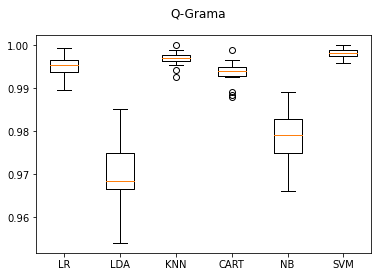

In [79]:
import matplotlib.pyplot as pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# load the dataset
# split into input (X) and output (y) variables
qgsim = sim.loc[:,sim.columns.str.startswith('qgsim')]
X = qgsim.iloc[20000:, 2:]
y = qgsim.iloc[20000:, 1]

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=20, random_state=None)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Q-Grama')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

LR: 0.995054 (0.002470)
LDA: 0.965263 (0.009235)
KNN: 0.996549 (0.001421)
CART: 0.993789 (0.002768)
NB: 0.980561 (0.004625)
SVM: 0.995658 (0.002375)


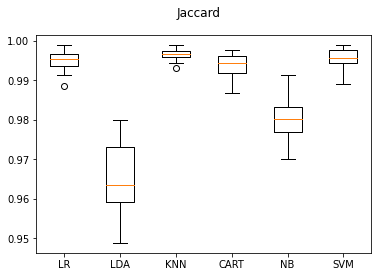

In [80]:
import matplotlib.pyplot as pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# load the dataset
# split into input (X) and output (y) variables
jaccsim = sim.loc[:,sim.columns.str.startswith('jaccsim')]
X = jaccsim.iloc[20000:, 2:]
y = jaccsim.iloc[20000:, 1]

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=20, random_state=None)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Jaccard')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show();

In [81]:
lcssim = sim.loc[:,sim.columns.str.startswith('lcssim')]
X = lcssim.iloc[20000:, 2:]
y = lcssim.iloc[20000:, 1]

LR: 0.996672 (0.002164)
LDA: 0.987537 (0.005324)
KNN: 0.997141 (0.001887)
CART: 0.994684 (0.001887)
NB: 0.990307 (0.003372)
SVM: 0.997856 (0.001636)


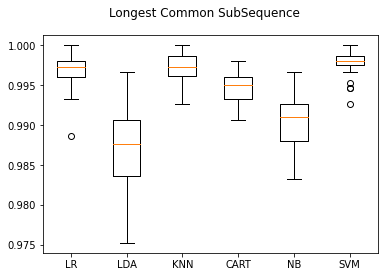

In [82]:
import matplotlib.pyplot as pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# load the dataset
LCSubSecsim = sim.loc[:,sim.columns.str.startswith('LCSubSecsim')]
X = LCSubSecsim.iloc[10000:, 2:]
y = LCSubSecsim.iloc[10000:, 1]

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=30, random_state=None)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Longest Common SubSequence')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show();

LR: 0.997677 (0.001344)
LDA: 0.973043 (0.006683)
KNN: 0.996471 (0.001164)
CART: 0.994439 (0.001965)
NB: 0.980838 (0.004449)
SVM: 0.998682 (0.000699)


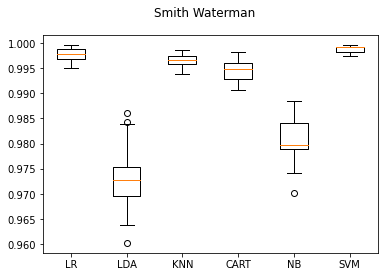

In [83]:
import matplotlib.pyplot as pyplot
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# load the dataset
# split into input (X) and output (y) variables
SWsim = sim.loc[:,sim.columns.str.startswith('SWsim')]
X = SWsim.iloc[10000:, 2:]
y = SWsim.iloc[10000:, 1]

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=20, random_state=None)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (
        name, 
        cv_results.mean(), 
        cv_results.std()
        )
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Smith Waterman')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show();

In [84]:
#select true match from all measures
nombre = sim[sim.columns[sim.columns.str.contains('nombre')]]
true_links = nombre[nombre.max(axis=1) >0.85].index
true_links

MultiIndex([(    10,      9),
            (    13,     12),
            (    21,     20),
            (    31,     30),
            (    47,     46),
            (    49,     48),
            (    50,     48),
            (    50,     49),
            (    53,     52),
            (    55,     54),
            ...
            (175793, 123835),
            (175797, 123843),
            (175799, 123851),
            (175799, 123852),
            (175802, 123858),
            (175805, 123867),
            (175812, 123883),
            (175813, 123883),
            (175813, 175812),
            (175830, 123903)],
           names=['level_0', 'level_1'], length=24515)

In [85]:
#Create binary classificaion
bin_labels = [0,1]
col = [
    'lsim', 'dlsim', 'jwsim', 'qgsim', 'csim', 'jaccsim', 'lcssim',
    'LCSubSecsim', 'SWsim'
]

for cols in col:
    sim[cols + 'Class'] = pd.cut(sim[cols],
                                 bins=[0,5, 6],
                                 labels=bin_labels)


sim['golden'] = (
    sim.loc[:,sim.columns.str.endswith('Class')]
    .max(axis=1)
    .dropna(axis=0)
    )

In [86]:
golden_pairs = sim[sim.columns[sim.columns.str.contains("golden")]][0:5000]
golden_pairs.head()

,,golden
level_0,level_1,
10,9,1.0
13,12,1.0
21,20,1.0
31,30,0.0
47,46,1.0


In [87]:
golden_matches_index = golden_pairs.index.intersection(true_links)
golden_matches_index

MultiIndex([(   10,     9),
            (   13,    12),
            (   21,    20),
            (   31,    30),
            (   47,    46),
            (   49,    48),
            (   50,    48),
            (   50,    49),
            (   53,    52),
            (   55,    54),
            ...
            (35127, 35126),
            (35129, 35121),
            (35129, 35122),
            (35129, 35123),
            (35142, 35141),
            (35148, 35147),
            (35173, 35172),
            (35176, 35175),
            (35196, 34861),
            (35216, 35215)],
           names=['level_0', 'level_1'], length=3608)

In [88]:
# Initialize the classifier
logreg = rl.LogisticRegressionClassifier()

In [89]:
# Train the classifier
logreg.fit(golden_pairs, golden_matches_index)
print ("Intercept: ", logreg.intercept)
print ("Coefficients: ", logreg.coefficients)

Intercept:  -2.344388855359114
Coefficients:  [6.55634123]


In [90]:
jwsim = sim[sim.columns[sim.columns.str.endswith("sim")]]


In [91]:
result_logreg = logreg.predict(jwsim.iloc[:,5:6])
len(result_logreg)

54776

In [92]:
rl.confusion_matrix(true_links, result_logreg, len(sim[sim.columns[sim.columns.str.endswith("sim")]]))

array([[24515,     0],
       [30261,     0]])

In [93]:
rl.fscore(true_links, result_logreg)

0.6183551727182153

In [94]:
golden_pairs.iloc[:3607,:]

,,golden
level_0,level_1,
10,9,1.0
13,12,1.0
21,20,1.0
31,30,0.0
47,46,1.0
...,...,...
26826,26825,1.0
26830,26829,1.0
26847,26846,1.0


In [95]:
# Train the classifier
svm = rl.SVMClassifier()
svm.fit(golden_pairs, golden_matches_index)

In [96]:
# Predict the match status for all record pairs
result_svm = svm.predict(jwsim.iloc[:,5:6])
len(result_svm)

54776

In [97]:
rl.confusion_matrix(true_links, result_svm, len(sim[sim.columns[sim.columns.str.endswith("sim")]]))

array([[24515,     0],
       [30261,     0]])

In [98]:
rl.fscore(true_links, result_svm)

0.6183551727182153

In [99]:
kmeans = rl.KMeansClassifier()
result_kmeans = kmeans.fit_predict(sim[sim.columns[sim.columns.str.endswith("sim")]])
len(result_kmeans)

31385

In [100]:
rl.confusion_matrix(true_links, result_kmeans, len(sim[sim.columns[sim.columns.str.endswith("sim")]]))

array([[ 1447, 23068],
       [29938,   323]])

In [101]:
rl.fscore(true_links, result_kmeans)

0.051771019677996424

In [102]:
# Train the classifier
ecm = rl.ECMClassifier(binarize=0.8)
result_ecm = ecm.fit_predict(sim[sim.columns[sim.columns.str.endswith("sim")]])
len(result_ecm)

54776

In [103]:
rl.confusion_matrix(true_links, result_ecm, len(sim[sim.columns[sim.columns.str.endswith("sim")]]))

array([[24515,     0],
       [30261,     0]])

In [104]:
rl.fscore(true_links, result_ecm)

0.6183551727182153